<a href="https://colab.research.google.com/github/ElSayedMMostafa/Deep-learning-Tasks/blob/main/Fish%20Dataset%20%7CTransfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">UST, Zewail City</h1>
<h2 align="center">CIE 555 (Spring 2021)</h2>
<h2 align="center">Lab 7: Convolutional Neural Networks: Part II</h2>
<h2 align="center">Lab Task</h2>




>  Student Name: **Elsayed Mohammed Mostafa** <br>
> Supervisied by: **Eng. Shahd Seddik**

# Imports

In [ ]:
import os
import numpy as np
import random 
from glob import glob
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from tensorflow import keras
from keras.layers import Dense 
from keras.models import Sequential 

## Functional API
from keras.models import Model
from keras.layers import * 

import cv2

# Dataset

**This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, 
black sea sprat, striped red mullet, trout, shrimp image samples.**

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1JNOf33sRfpG2xsV2ULSZ5638eBBQRKBn'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [ ]:
!mkdir /content/fish_dataset
!unzip -q /content/archive.zip -d /content/fish_dataset 

In [ ]:
# Print the classes names and save their pathes
DATASET_DIR = "/content/fish_dataset/Fish_Dataset/Fish_Dataset"
ClASSES_DIRS =[]
for dir in os.listdir(DATASET_DIR):
  if dir[-4:] != '.txt' and dir[-2:] != '.m':
    ClASSES_DIRS.append(dir)

print('The available classes in the dataset: ')
print(ClASSES_DIRS)

The available classes in the dataset: 
['Red Mullet', 'Sea Bass', 'Gilt-Head Bream', 'Black Sea Sprat', 'Shrimp', 'Hourse Mackerel', 'Red Sea Bream', 'Trout', 'Striped Red Mullet']


Saving all the images, labels in lists

In [ ]:
all_data = []
for DIR in ClASSES_DIRS:
  CLASS_DIR = os.path.join(DATASET_DIR,DIR,DIR)
  
  class_data = [y for x in os.walk(CLASS_DIR) for y in glob(os.path.join(x[0], '*png'))]
  all_data.extend(class_data)

all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]

Checking the number of the data points (images)

In [ ]:
print(len(all_data))

9000


Sample some images from the dataset


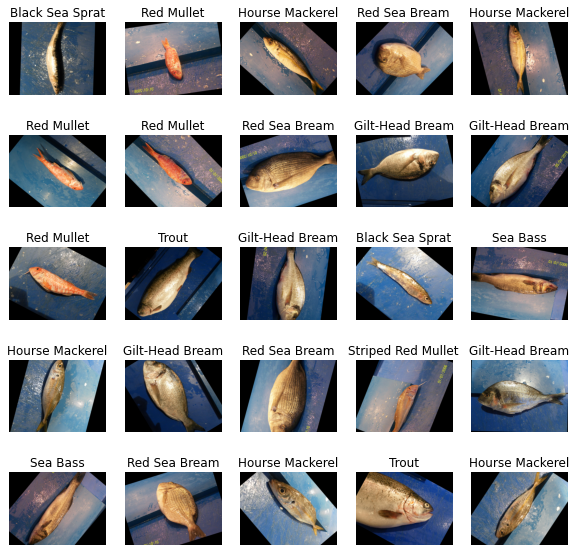

In [ ]:
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

***Saving all the paths of images and their labels in 2 lists for data generators***

In [ ]:
images_paths = []
labels = []
for dir in ClASSES_DIRS:
  CLASS_DIR = os.path.join(DATASET_DIR,dir,dir)
  for img in os.listdir(CLASS_DIR):
    img_path = os.path.join(CLASS_DIR, img)
    images_paths.append(img_path)
    labels.append(dir)

In [ ]:
# Take a look at the lengthes of the lists
len(images_paths), len(labels)

(9000, 9000)

In [ ]:
# Take a look at the lists
images_paths[12], labels[12]

('/content/fish_dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00167.png',
 'Red Mullet')

***Generating the dataframe for train-test splitting***

In [ ]:
data_df = pd.DataFrame.from_dict({"image_path": images_paths,
                         "label":labels})
data_df.head()

,image_path,label
0,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Red Mullet
1,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Red Mullet
2,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Red Mullet
3,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Red Mullet
4,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Red Mullet


In [ ]:
# Train/Test split
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 17, shuffle = True)
train_df.head()

,image_path,label
2309,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Gilt-Head Bream
4942,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Shrimp
2390,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Gilt-Head Bream
3667,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Black Sea Sprat
1491,/content/fish_dataset/Fish_Dataset/Fish_Datase...,Sea Bass


In [ ]:
print('Training data shape= ', train_df.shape)
print('Test data shape= ', test_df.shape)

Training data shape=  (7200, 2)
Test data shape=  (1800, 2)


**Construct the training data gernerator**

In [ ]:
BATCH_SIZE = 64
HEIGHT = 200
WIDTH = 200
VAL_SPLIT = 0.2

# 'ImageDataGenerator' class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
      validation_split = VAL_SPLIT
    )

# Training data generator
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col = 'image_path',
                                                    y_col = 'label',
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


**Construct the test data gernerator**

In [ ]:

test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    )

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  shuffle = False,
                                                  x_col = 'image_path',
                                                  y_col = 'label',
                                                  target_size=(HEIGHT, WIDTH), 
                                                  batch_size=BATCH_SIZE,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 1800 validated image filenames belonging to 9 classes.


In [ ]:
images, labels = next(train_generator)

print(images.shape)
print(labels.shape)

(64, 200, 200, 3)
(64, 9)


# **Model**

**Construct the deep learning model [TRANSFER LEARNING]** <br>
 <br>
My choise is to use ResNet50 model. As the data is relatively small with somehow different data than ImagNet. I would train some of the network parameters in the convolution layers. Also, additional fully connected layers are added.<br>
<br>
For the learning rate, I'll put it 0.0001 as the model is expected to converge easily. The loss function is 'categorical crossentropy' and the evaluation metric is 'categorical accuracy' due to the problem nature.

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout

# Load model without classification head
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model.summary()

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

for layer in base_model.layers[-4:-1]:
  layer.trainable = True

# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['categorical_accuracy'])

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

***Let's train the model***

In [ ]:
# I can choose small number of epochs as the model is expected to converge quickly
INITIAL_EPOCHS = 8

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/8
90/90 [==============================] - 125s 1s/step - loss: 14.0412 - categorical_accuracy: 0.6143 - val_loss: 0.3446 - val_categorical_accuracy: 0.9542
Epoch 2/8
90/90 [==============================] - 119s 1s/step - loss: 0.2318 - categorical_accuracy: 0.9655 - val_loss: 0.0691 - val_categorical_accuracy: 0.9868
Epoch 3/8
90/90 [==============================] - 118s 1s/step - loss: 0.0952 - categorical_accuracy: 0.9847 - val_loss: 0.7446 - val_categorical_accuracy: 0.9292
Epoch 4/8
90/90 [==============================] - 118s 1s/step - loss: 0.1807 - categorical_accuracy: 0.9770 - val_loss: 0.0145 - val_categorical_accuracy: 0.9965
Epoch 5/8
90/90 [==============================] - 118s 1s/step - loss: 0.0909 - categorical_accuracy: 0.9859 - val_loss: 0.1460 - val_categorical_accuracy: 0.9799
Epoch 6/8
90/90 [==============================] - 118s 1s/step - loss: 0.0553 - categorical_accuracy: 0.9944 - val_loss: 0.0111 - val_categorical_accuracy: 0.9972
Epoch 7/8
90/90

***Plotting training VS validation accuracy/loss***

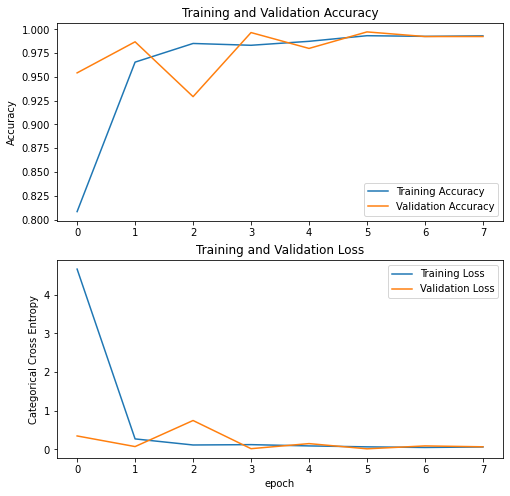

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Model Evaluation**

In [ ]:
model.evaluate(test_generator)

29/29 [==============================] - 18s 617ms/step - loss: 0.0787 - categorical_accuracy: 0.9917


[0.07868732511997223, 0.9916666746139526]

***AWESOME! A very high accuracy is obtained through less training compared to the traditional deep learning models/methods***

*Model Prediction*

In [ ]:
# Model Predection
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

***Confusion Report***

In [ ]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       205
           1       1.00      0.97      0.98       214
           2       0.98      1.00      0.99       189
           3       1.00      1.00      1.00       193
           4       0.97      1.00      0.99       204
           5       0.98      1.00      0.99       206
           6       1.00      1.00      1.00       205
           7       1.00      1.00      1.00       186
           8       1.00      0.99      1.00       198

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



***Confusion Matrix***

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

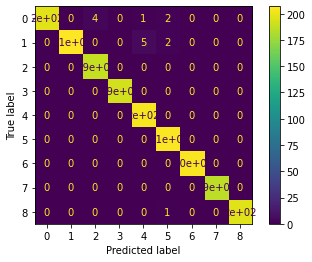

In [ ]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.array(ClASSES_DIRS))
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.array(range(9)))
cm_disp.plot();

**LONG LIVE THE TRANSFER LEARNING !!**